<a href="https://colab.research.google.com/github/amarjit420/Vector_Demos/blob/main/Astra_Vector_Hybrid_Search_Cheese_Demo_v4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Astra Vector Embedding Search with Text Analyser

Jupyter notebook for image search powered by [Astra Vector Search](https://docs.datastax.com/en/astra-serverless/docs/vector-search/overview.html) and Hugging Face Sentence Transfromer [obrizum/all-MiniLM-L6-v2].



---



## Transformer Model
This is a sentence-transformers model: It maps sentences & paragraphs to a 384 dimensional dense vector space and can be used for tasks like clustering or semantic search.

The model is intented to be used as a sentence and short paragraph encoder. Given an input text, it ouptuts a vector which captures the semantic information. The sentence vector may be used for information retrieval, clustering or sentence similarity tasks.


## Astra Vector Search
Astra vector search enables developers to search a database by context or meaning rather than keywords or literal values. This is done by using “embeddings”. Embeddings are a type of representation used in machine learning where high-dimensional or complex data is mapped onto vectors in a lower-dimensional space. These vectors capture the semantic properties of the input data, meaning that similar data points have similar embeddings.

## Astra Hybrid Queries


Hybrid queries leverage VSS in conjunction with predicates (aka "filters") on other columns. Using partition keys, clustering columns, and indexed SAI columns, you can write expressive hybrid queries that order the column filtered search results by their similarity to the semantic search vector.
Think about trying to find a product on your favorite retailer's website. VSS can use what we type into the search box to find related products, but what if we only want it in color:blue or size:medium? To get specific about what we're looking for, semantic search needs some help from more conventional query terms.

---

## Demo Summary
The demo showcases the transformer model, which generates embeddings for images. These embeddings, along with metadata, are stored in Astra DB. Specifically, the embeddings are stored in a column of type Vector, in addition an analyzer SAI index is also created on the description column.

The goal of the demo is to utilize Astra Hybrid Search to search for different types of cheese based on the semantics of the vector search and the SAI index.


## Sample Data

The sample dataset is in the following JSON format, screen scrapped from (http://cheese.com)

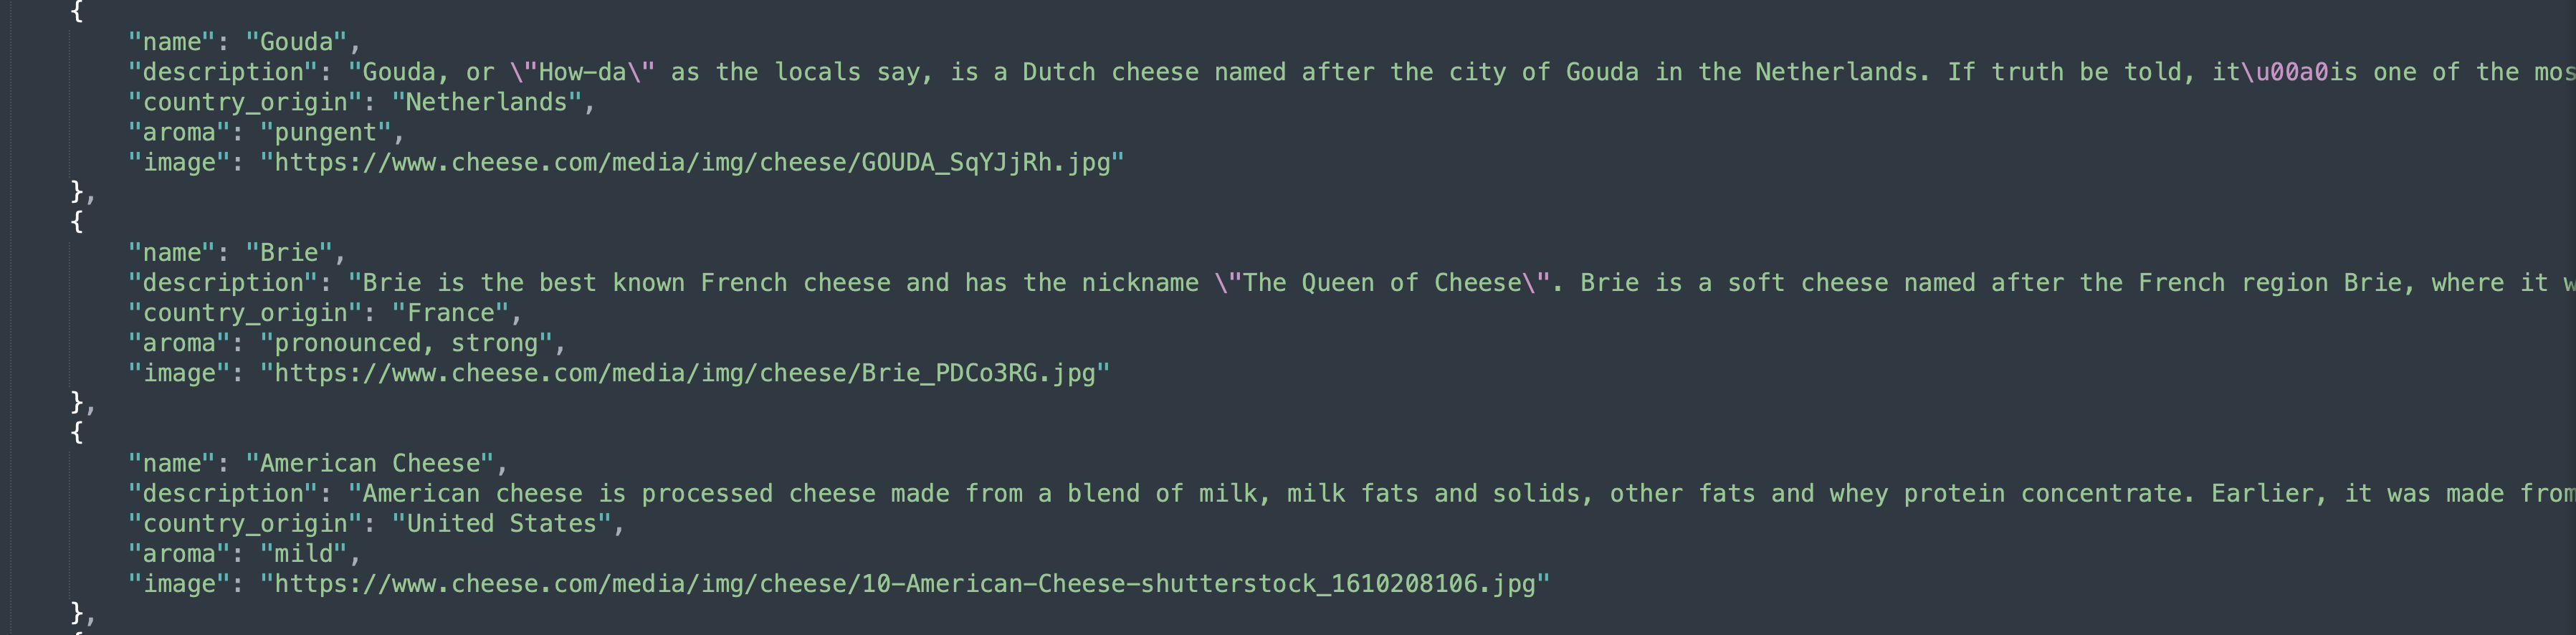

#Set Up AstraDB   

Create a serverless vector database with Astra Vector Search and set up its schema.



Steps

1. **Login to DataStax Astra** (https://astra.datastax.com) and log in.
2. **Create a New Database** Go to the *Databases* tab and click *Create* Database.


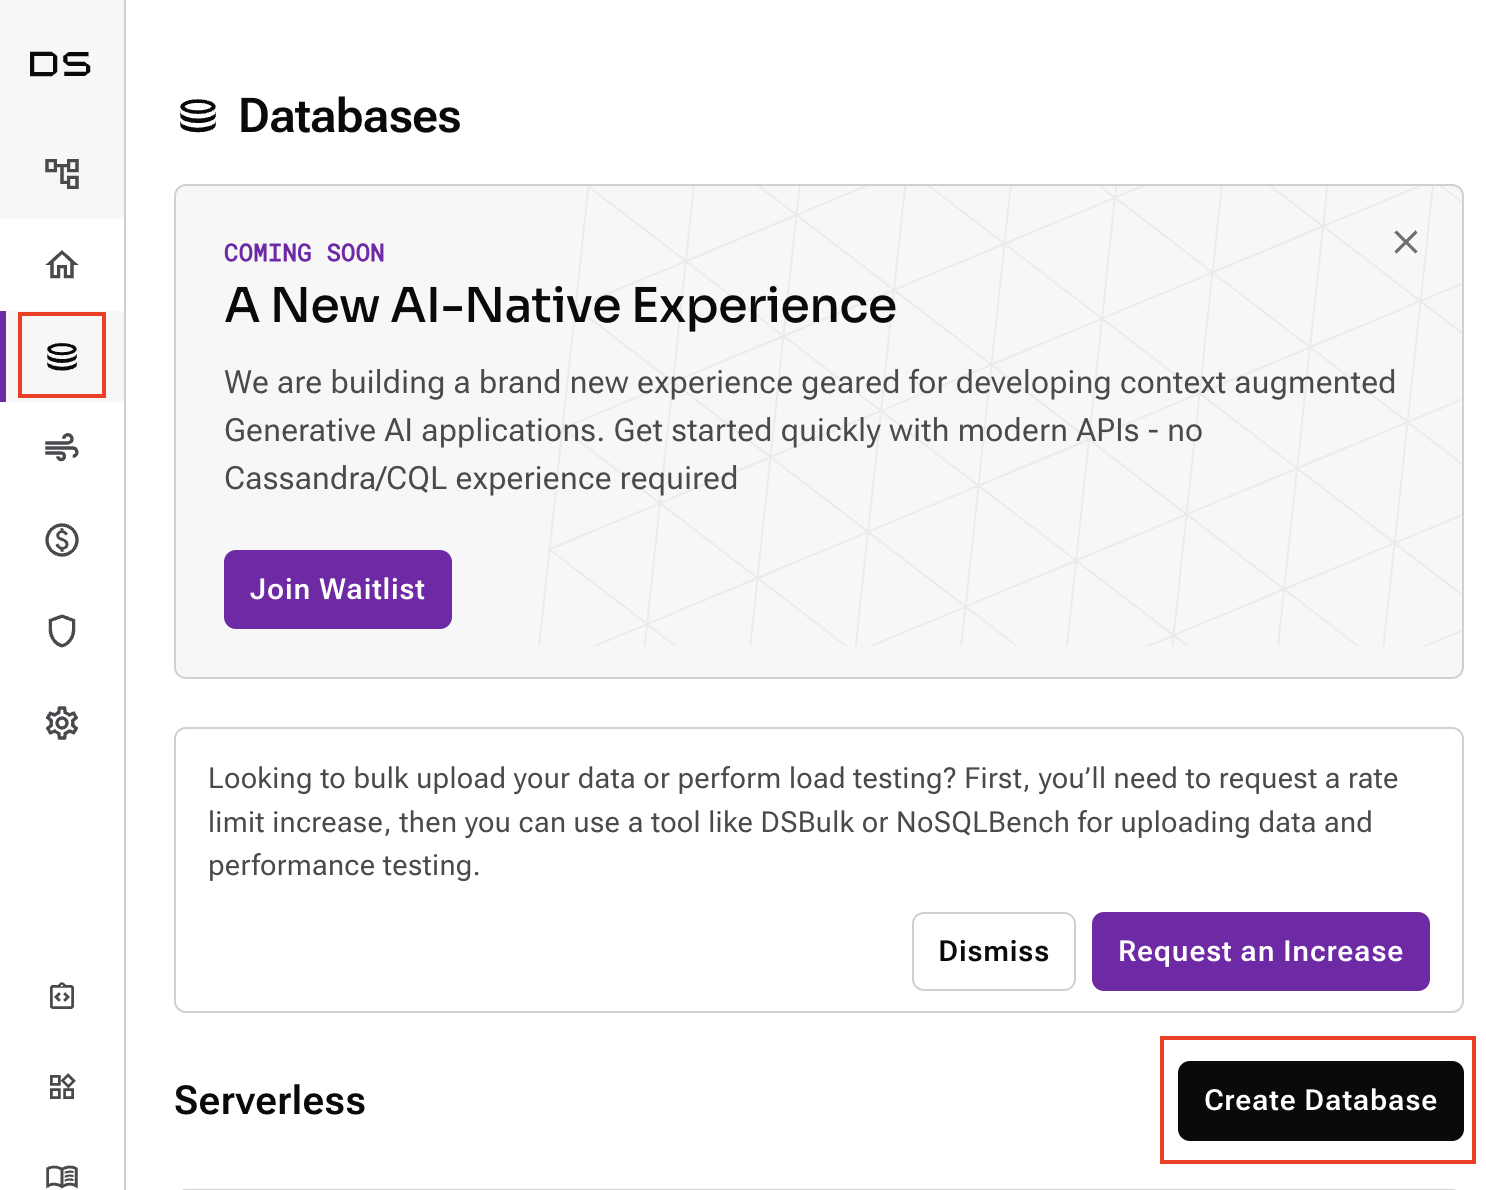

3. **Configure Your Database** Provide the required information:

- Database Name
- Keyspace Name
- Cloud Provider
- Region Be sure to select Vector Database as the type at the top.

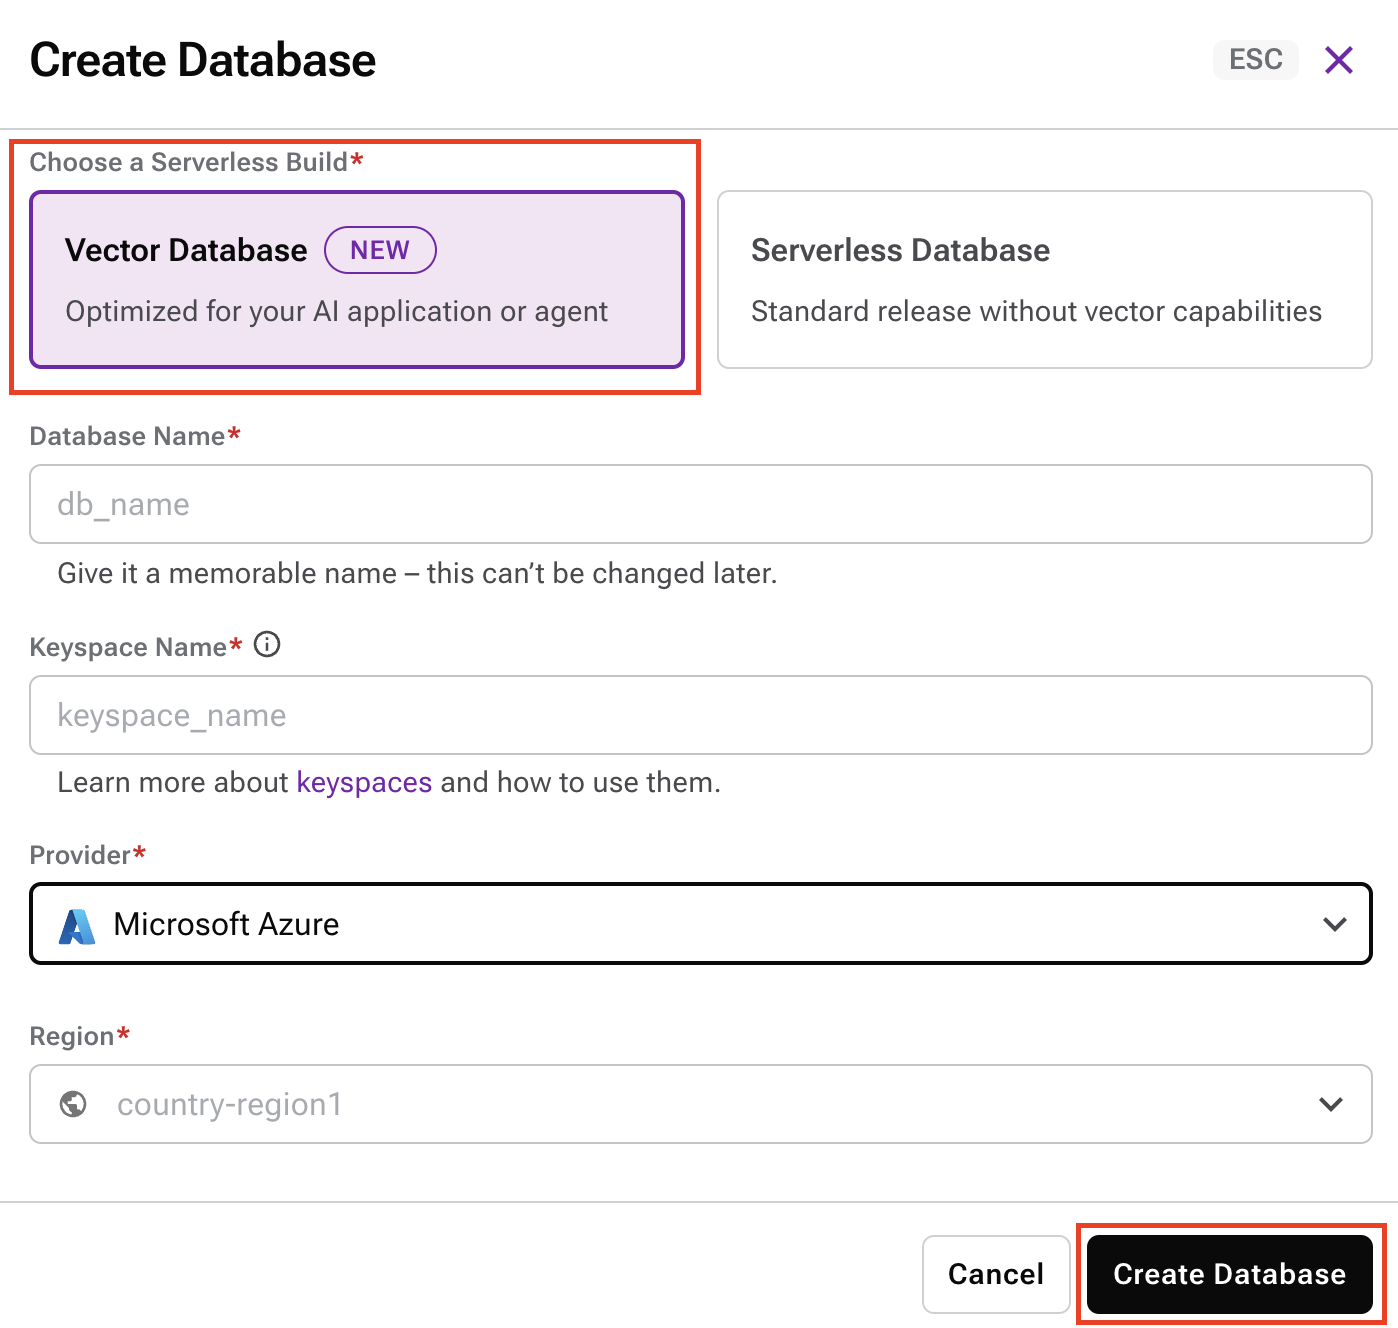



4. **Database Initialization** Wait for your database to be ready. Check status on the dashboard.

5. **Connection** Once ready, click Connect for connection details.


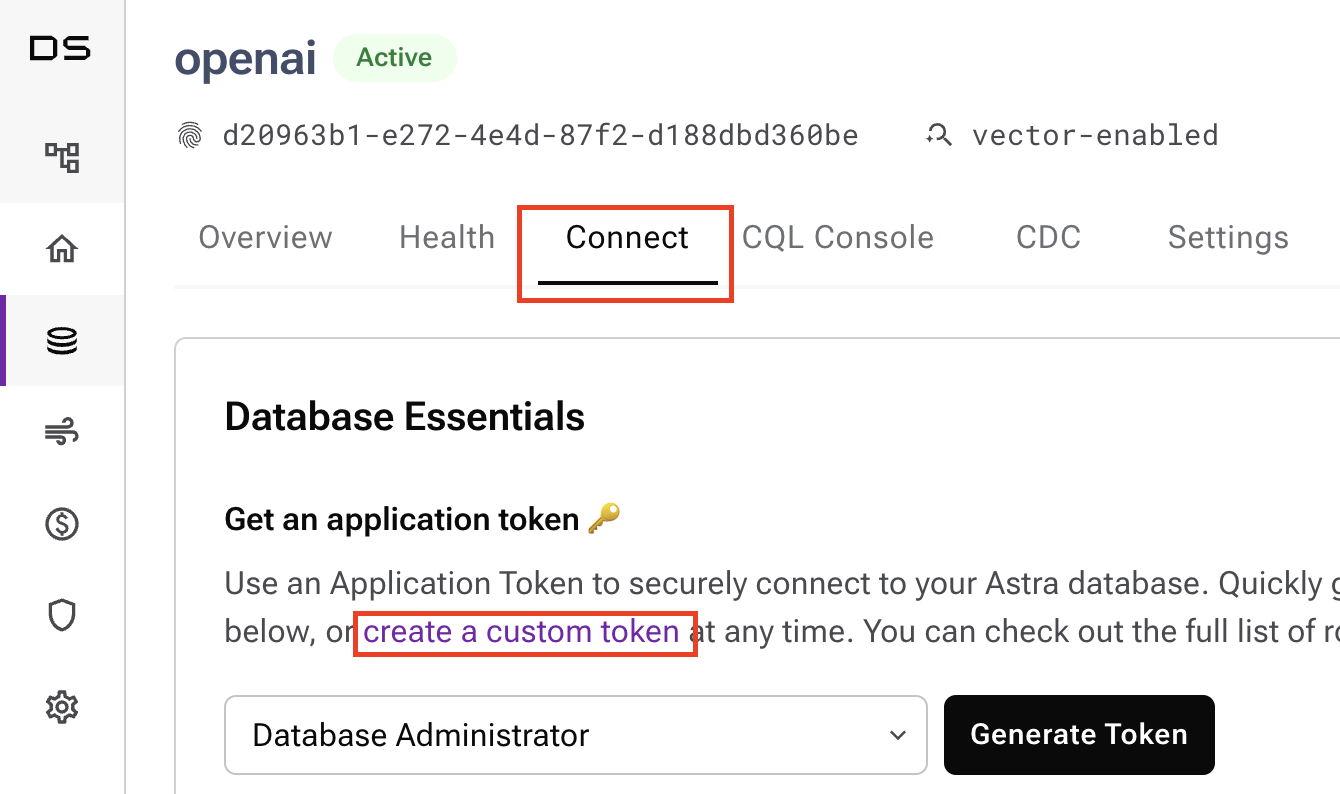

6. **Token Generation** Click "create a custom token" (or navigate to Settings -> Tokens) in the Astra DB console. Select the required permissions. For this tutorial, we will use Database Administrator as the role. Click Generate Token. Save the generated credentials securely. You will not be able to retrieve them again.


## Install Dependencies


 Package           | Details         
-------------------|:----------------
*`Cassandra Driver`*   |A Python client driver for Apache Cassandra®. This driver works exclusively with the Cassandra Query Language v3 (CQL)
*`Sentence Transformer`* | SentenceTransformers is a Python framework for sentence, text and image embeddings|
*`Pandas`* | Flexible and easy to use open source data analysis and manipulation package





In [ ]:
!pip3 install cassandra-driver matplotlib sentence-transformers pandas

# Imports

In [ ]:
import os

from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

from PIL import Image
from sentence_transformers import SentenceTransformer
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
from getpass import getpass

# Astra Variables

Vector database credentials and secure connect bundle

 Package           | Details         
-------------------|:----------------
*`Token`*   |Application tokens allow you to connect to your database from your application
*`Keyspace`* | A top-level database object which can hold multiple tables|
*`Table`* | Holds your data

In [ ]:
# Input your Astra DB token string, the one starting with "AstraCS:..."
ASTRA_DB_TOKEN_BASED_PASSWORD = getpass('Your Astra DB Token ("AstraCS:..."): ')

Your Astra DB Token ("AstraCS:..."): ··········


In [ ]:
# Input your database keyspace name:
ASTRA_DB_KEYSPACE = input('Your Astra DB Keyspace name (e.g. imagevecs): ')

Your Astra DB Keyspace name (e.g. imagevecs): ks1


In [ ]:
# Input your database table name:
ASTRA_DB_TABLE = input('Your Astra DB Table name (e.g. cheese): ')

Your Astra DB Table name (e.g. cheese): testvs_1


In [ ]:
# Upload your Secure Connect Bundle zipfile:
import os
from google.colab import files


print('Please upload your Secure Connect Bundle')
uploaded = files.upload()
if uploaded:
    astraBundleFileTitle = list(uploaded.keys())[0]
    scb_path = os.path.join(os.getcwd(), astraBundleFileTitle)
else:
    raise ValueError(
        'Cannot proceed without Secure Connect Bundle. Please re-run the cell.'
    )

Please upload your Secure Connect Bundle


Saving secure-connect-cassio-v1.zip to secure-connect-cassio-v1.zip


In [ ]:
SECURE_CONNECT_BUNDLE_PATH = scb_path
ASTRA_CLIENT_ID = 'token'
ASTRA_CLIENT_SECRET = ASTRA_DB_TOKEN_BASED_PASSWORD
KEYSPACE_NAME = ASTRA_DB_KEYSPACE
TABLE_NAME = ASTRA_DB_TABLE

# Connect to Astra DB

In [ ]:
cloud_config = {
   'secure_connect_bundle': SECURE_CONNECT_BUNDLE_PATH
}
auth_provider = PlainTextAuthProvider(ASTRA_CLIENT_ID, ASTRA_CLIENT_SECRET)
cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider, protocol_version=4)
session = cluster.connect()

# Review data model


The sample data is in the format

```
    {
        "name": "Brie",
        "description": "Brie is the best known French cheese and has the nickname ....",
        "country_origin": "France",
        "aroma": "pronounced, strong",
        "image": "https://www.cheese.com/media/img/cheese/Brie_PDCo3RG.jpg"
    },
```

The following table schema is used in the demo:

```
CREATE TABLE IF NOT EXISTS ks1.cheese (
   id int PRIMARY KEY,
   description TEXT,
   name TEXT,
   aroma TEXT,
   country_origin TEXT,
   image TEXT,
   item_vector VECTOR<FLOAT, 384>
  )
```


## Create your table

In [ ]:
print(f"Creating table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"CREATE TABLE IF NOT EXISTS {KEYSPACE_NAME}.{TABLE_NAME} (id int PRIMARY KEY, description TEXT, name TEXT, aroma TEXT, country_origin TEXT, image TEXT, item_vector VECTOR<FLOAT, 384>)")

Creating table testvs_1 in keyspace ks1


## Vector index

In [ ]:
print(f"Creating index on the vector element on table {TABLE_NAME} ")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME}(item_vector) USING 'StorageAttachedIndex'")

Creating index on the vector element on table testvs_1 


## Analyzer index

Create an SAI index with the index_analyzer option and stemming enabled, in this example we are using the Poterstem token filter.  Other options include:

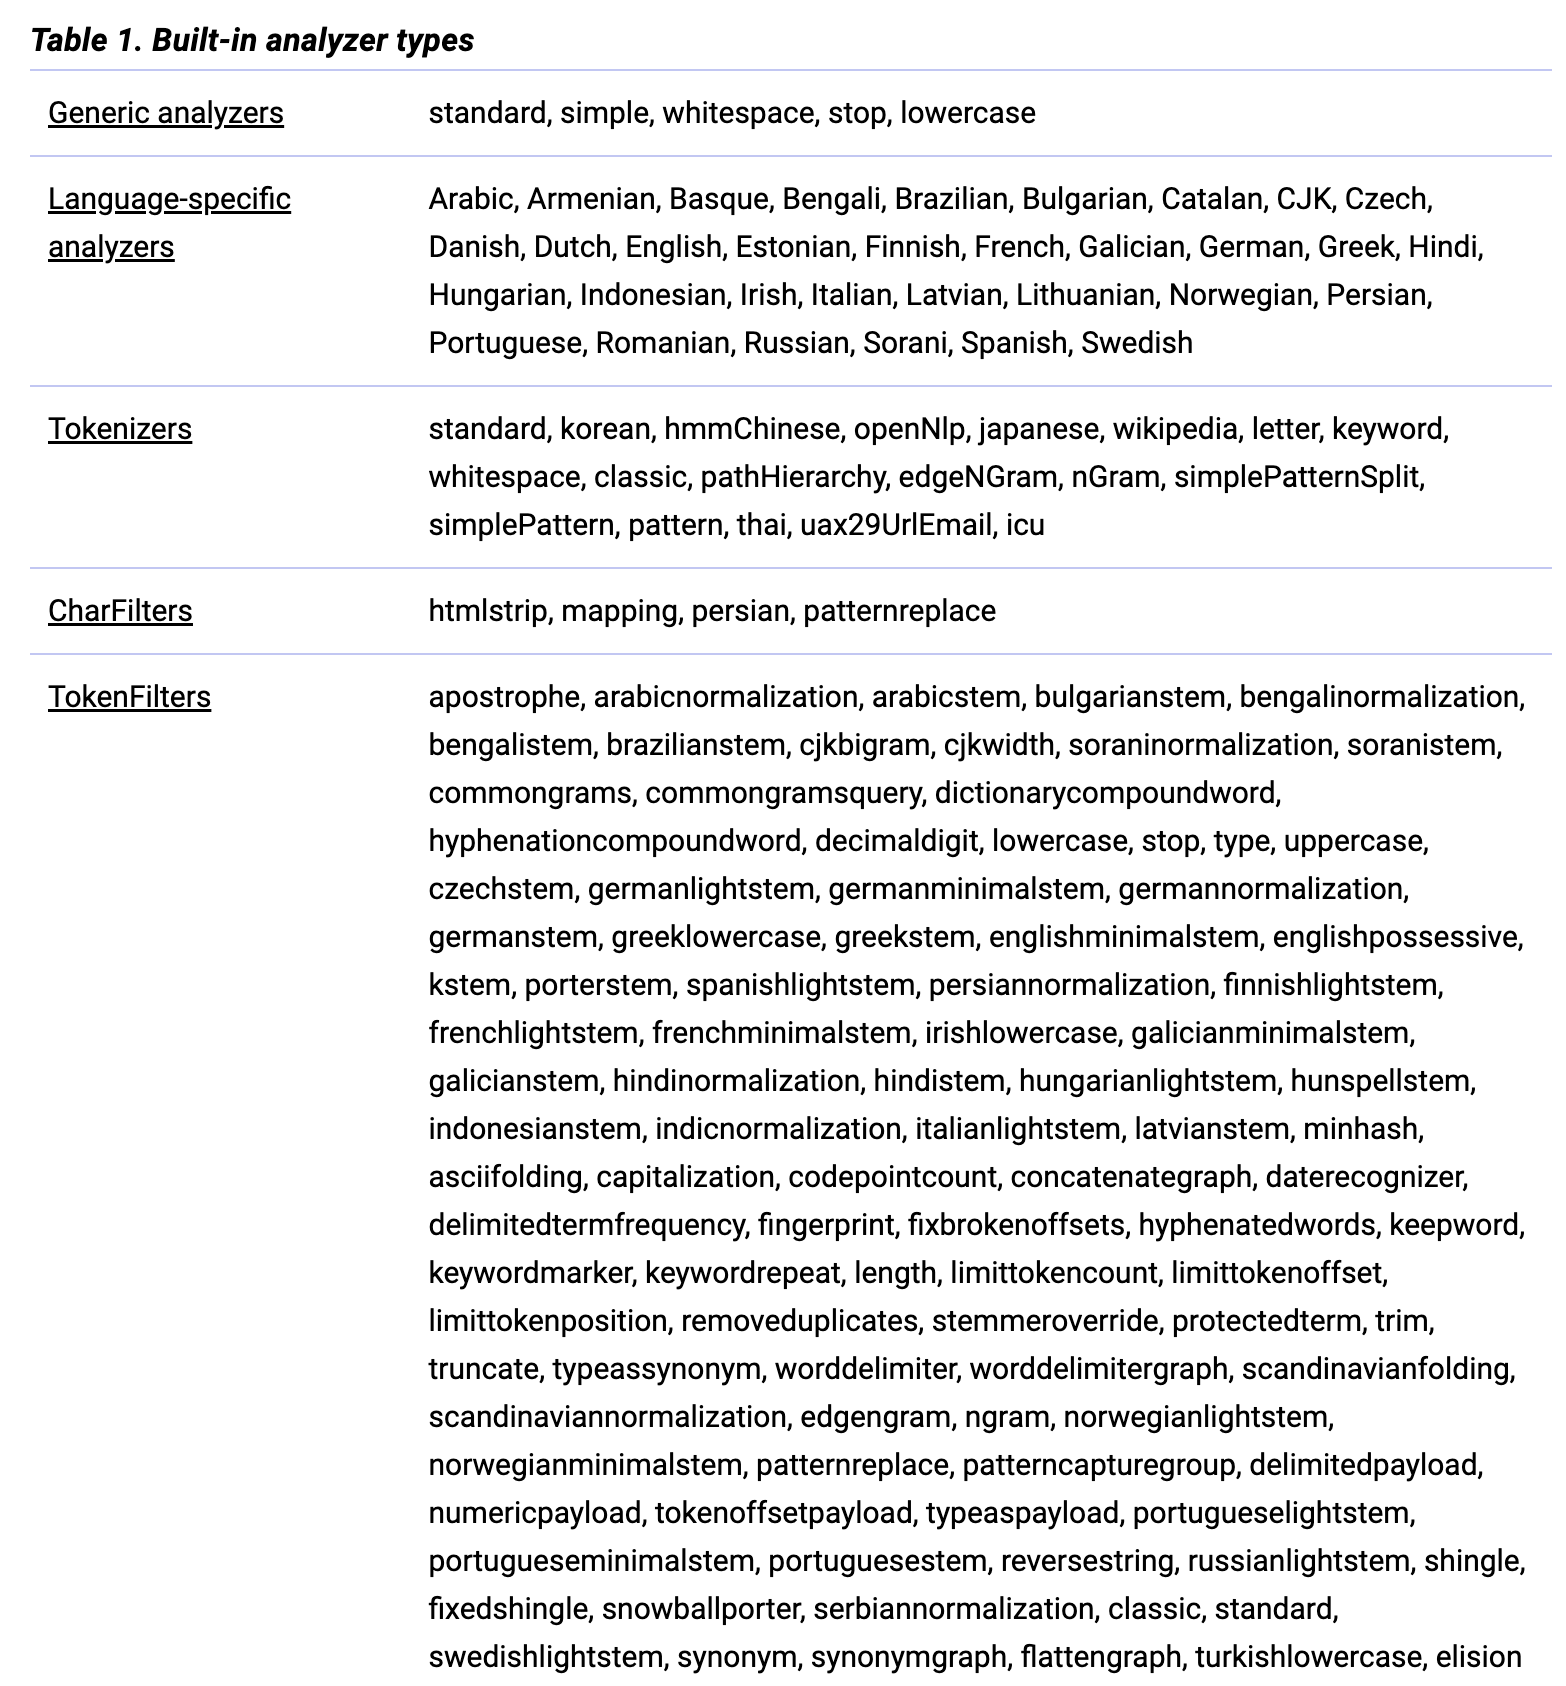



The following indexes are used in the demo:

```
CREATE CUSTOM INDEX ON {KEYSPACE_NAME}.{TABLE_NAME}(description)
USING 'StorageAttachedIndex'
WITH OPTIONS = { 'index_analyzer':
                   '{"tokenizer" :
                         {"name" : "standard"},
                          "filters" :
                             [{
                                "name" : "porterstem"
                              }]}
                '};
```

```
CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME}(item_vector) USING 'StorageAttachedIndex'
```

In [ ]:
print(f"Creating tokenizer index on the description element on table {TABLE_NAME} ")
session.execute(f"""CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME} (description) USING 'StorageAttachedIndex' WITH OPTIONS = {{'index_analyzer': '{{"tokenizer" : {{"name" : "standard"}},"filters" : [{{"name" : "porterstem"}},{{"name" : "lowercase",      "args": {{}}}}]}}'}};""")

Creating tokenizer index on the description element on table testvs_1 


In [ ]:
print(f"Creating index on the name")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME} (name) USING 'StorageAttachedIndex'")
print(f"Creating index on the aroma")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME} (aroma) USING 'StorageAttachedIndex'")
print(f"Creating index on the country_origin")
session.execute(f"CREATE CUSTOM INDEX IF NOT EXISTS ON {KEYSPACE_NAME}.{TABLE_NAME} (country_origin) USING 'StorageAttachedIndex'")

Creating index on the name
Creating index on the aroma
Creating index on the country_origin


## Drop the table

incase this demo is re-run

In [ ]:
print(f"Truncate table {TABLE_NAME} in keyspace {KEYSPACE_NAME}")
session.execute(f"TRUNCATE TABLE {KEYSPACE_NAME}.{TABLE_NAME}")

Truncate table testvs_1 in keyspace ks1



**Load the model**

This is a pretrained model and fine-tuned in on a 1B sentence pair dataset.

Given an input text, the model ouptuts a vector which captures the semantic information. The sentence vector may be used for information retrieval, clustering or sentence similarity tasks.

In [ ]:
model = SentenceTransformer('obrizum/all-MiniLM-L6-v2')


# Simple test

In [ ]:
text_emb = model.encode("Astra DB is awesome!")
print(f"model provided embeddings for the string: '. {text_emb.tolist()}")
print(f"vector size:  {len(text_emb)}")


model provided embeddings for the string: '. [-0.0484294630587101, -0.06395214051008224, -0.12165360897779465, 0.07729779928922653, -0.07804174721240997, -0.011682888492941856, 0.03413830325007439, -0.012230229564011097, -0.025593165308237076, -0.019768938422203064, 0.005844108294695616, 0.04004105180501938, 0.03609120845794678, -0.008678545244038105, -0.028357986360788345, 0.0038448756095021963, 0.0877026692032814, -0.049065589904785156, 0.02829134650528431, -0.04521230235695839, -0.0870819091796875, -0.051713764667510986, 0.03044814243912697, 0.07942403852939606, 0.07801339030265808, -0.0273881908506155, -0.07334809005260468, -0.029019193723797798, -0.002857337472960353, -0.217091366648674, -0.010920040309429169, 0.043753769248723984, 0.008626569993793964, 0.052585113793611526, -0.06797506660223007, -0.041222792118787766, 0.0060409968718886375, -0.06536903232336044, -0.08671985566616058, -0.04040306806564331, -0.039124466478824615, 0.00617589708417654, -0.03278345987200737, 0.0266336

# Load the JSON test data

In [ ]:
import json
import requests

def clean_description(text):
    # Remove carriage returns and newlines
    cleaned_text = text.replace('\n', ' ').replace('\r', ' ')
    # Remove commas and special characters
    cleaned_text = ''.join(char for char in cleaned_text if char.isalnum() or char.isspace())
    #return cleaned_text[:250]  # Limit description to 250 characters after cleaning
    return cleaned_text[:250]  # Limit description to 250 characters after cleaning


# Function to extract image URLs from the description text
def extract_image_urls(description):
    words = description.split()
    image_urls = [word for word in words if word.startswith("https://") and word.endswith(".jpg")]
    return image_urls[0] if image_urls else 'Image URL not found'

image_data = []

# Use the raw GitHub URL to get the actual JSON content
response = requests.get('https://raw.githubusercontent.com/amarjit420/Vector_Demos/main/Data/cheese_data.json')
response.raise_for_status()  # This will raise an error if the request failed
cheese_data = response.json()

# Fix the indentation for the loop
for index, cheese_entry in enumerate(cheese_data, start=1):
    name = cheese_entry.get('name', 'Unknown')
    description = clean_description(cheese_entry.get('description', 'No description available'))
    country_origin = cheese_entry.get('country_origin', 'Unknown')
    aroma = cheese_entry.get('aroma', 'Unknown')
    image_url = extract_image_urls(cheese_entry.get('image', ''))

    # Place holder embedding
    embedding = '1111.1111'

    # Create the image_data structure
    image_data.append((index, name, description, aroma, country_origin, image_url, embedding))

# Pretty print the image_data
print(json.dumps(image_data, indent=4))



[
    [
        1,
        "Gouda",
        "Gouda as the locals say is a Dutch cheese named after the city of Gouda in the Netherlands The taste can vary depending on its aging process It is the most popular Dutch cheese in the world accounting for 50 to 60 of the worlds cheese consumption Sin",
        "Unknown",
        "Netherlands",
        "https://www.cheese.com/media/img/cheese/GOUDA_SqYJjRh.jpg",
        "1111.1111"
    ],
    [
        2,
        "Brie",
        "Brie cheese is a soft and creamy French cheese known for its mild buttery flavour It is named after the Brie region in France where it originated Brie is traditionally made from cows milk and is often produced in large wheels or rounds Brie is a soft",
        "buttery, mild",
        "France",
        "https://www.cheese.com/media/img/cheese/Brie_PDCo3RG.jpg",
        "1111.1111"
    ],
    [
        3,
        "American Cheese",
        "American cheese often found in households and restaurants across the United St

## Insert data

Insert the sample JSON data with the vector embedding into Astra table


In [ ]:
for cheese_tuple in image_data:
    index = cheese_tuple[0]
    name = cheese_tuple[1]
    description = cheese_tuple[2]
    aroma = cheese_tuple[3]
    country = cheese_tuple[4]
    image_url = cheese_tuple[5]
    embeddings = model.encode(name).tolist()
    print("Vectorisation of ", name)
    print("Embedding is: ", embeddings)

    session.execute(
        f"INSERT INTO {KEYSPACE_NAME}.{TABLE_NAME} (id, description, name, aroma, country_origin, image, item_vector) VALUES {index, description, name, aroma, country, image_url, embeddings}")

Vectorisation of  Gouda
Embedding is:  [0.030271466821432114, -0.010784965008497238, -0.05597635731101036, 0.0064066993072628975, -0.0865413099527359, 0.02157481014728546, 0.08221592009067535, -0.005079485476016998, -0.01404733769595623, -0.05516144633293152, 0.10006479918956757, -0.04404615983366966, -0.03205018863081932, 0.022445639595389366, 0.015694815665483475, -0.05096998065710068, 0.024073950946331024, -0.12951545417308807, 0.021541114896535873, -0.03000224009156227, -0.02235867641866207, 0.061212897300720215, -0.02119119092822075, -0.005372048355638981, -0.06006879359483719, 0.06359568983316422, 0.04376475512981415, -0.08200682699680328, -0.024741386994719505, -0.0857648029923439, 0.02387508563697338, 0.027903882786631584, -0.008350016549229622, -0.034365762025117874, -0.07832509279251099, -0.05330358073115349, -0.004582103807479143, -0.018887685611844063, -0.01042420044541359, 0.06536272913217545, -0.03505091369152069, -0.00028446968644857407, 0.006299046333879232, -0.02306555

## Perform a text based search on the description field

Test the **analyser indexer** with a text based search, you can change the text word to test different scenarios.


 Text           | Example         
-------------------|:----------------
*`age`*   |age, aged, ageing
*`blend`*   |blending, blend, blended
*`distinct`*   |distinctively, distinctive




In [ ]:
import pandas as pd

text_search = "United States"


query = f"SELECT id, name, aroma, country_origin FROM {KEYSPACE_NAME}.{TABLE_NAME} where description : '{text_search}' LIMIT 7"

results = session.execute(query)
top_results = results._current_rows

with pd.option_context('display.max_rows', 7,
                       'display.max_columns', None,
                       'display.width', 2000,
                       'display.colheader_justify', 'center'):

    df = pd.DataFrame(top_results, columns = [ 'ID', 'Name', 'Aroma', 'Country' ])
    print(df)

   ID       Name             Aroma          Country    
0  53         Dry Jack  aromatic, earthy  United States
1   3  American Cheese              mild  United States


## Perform a vector based search on the embedded field

Test the **semantic vector** embedding with a cheese name in the dataset
i.e.

*   *Brie* for an exact match
*   *Edam* for a nearest neighbour match (Edam not in dataset)
*   *Smokey* / *English* / *Blue* for a semantic search of that type of cheese


In [ ]:
import pandas as pd

query_string = "United States"

text_emb = model.encode(query_string)
print(f"model provided embeddings for the string: '. {text_emb.tolist()}")

embeddings_str = ", ".join(map(str, text_emb.tolist()))
query = f"SELECT id, name, aroma, country_origin FROM {KEYSPACE_NAME}.{TABLE_NAME}  ORDER BY item_vector ANN OF [{embeddings_str}] LIMIT 7"

results = session.execute(query)
top_results = results._current_rows

with pd.option_context('display.max_rows', 7,
                       'display.max_columns', None,
                       'display.width', 2000,
                       'display.colheader_justify', 'center'):

    df = pd.DataFrame(top_results, columns = [ 'ID', 'Name', 'Aroma', 'Country' ])
    print(df)


model provided embeddings for the string: '. [0.06430634111166, -0.0023302901536226273, 0.0029811328276991844, 0.04354546591639519, -0.011129925958812237, -0.0044065131805837154, 0.04068455472588539, -0.053016409277915955, -0.013187718577682972, 0.015267073176801205, 0.02876388654112816, -0.038836851716041565, 0.03568102419376373, -0.003907563630491495, -0.050017137080430984, -0.0274795088917017, 0.036722034215927124, -0.06929486989974976, -0.07632485777139664, -0.03569680452346802, 0.045598145574331284, 0.042284443974494934, 0.024942288175225258, 0.025544535368680954, 0.017039848491549492, 0.04884093627333641, -0.010355223901569843, 0.019619744271039963, 0.014366432093083858, -0.10557366907596588, -0.019443299621343613, -0.04299592599272728, 0.043945953249931335, -0.022348521277308464, -0.008497396484017372, -0.05134602263569832, 0.025890113785862923, -0.02356390468776226, 0.024617405608296394, -0.024733223021030426, 0.010483479127287865, -0.06201248615980148, 0.015580405481159687, 0.

## Hybrid search across vector embedding and text

An advantage of the DataStax approach to hybrid search is that it's an efficient, one-pass implementation that does not require a high-latency relevancy/re-ranking pass to output useful results.

Test the hybrid search of the semantic search with a text i.e.

* Vector search of *Blue* and text of *Creamy*
* Vector search of *hard* and text of *Nutty*
* Vector search of *Smooth* and text of *Mature*
* Vector search of *English* and text of *Farmhouse*


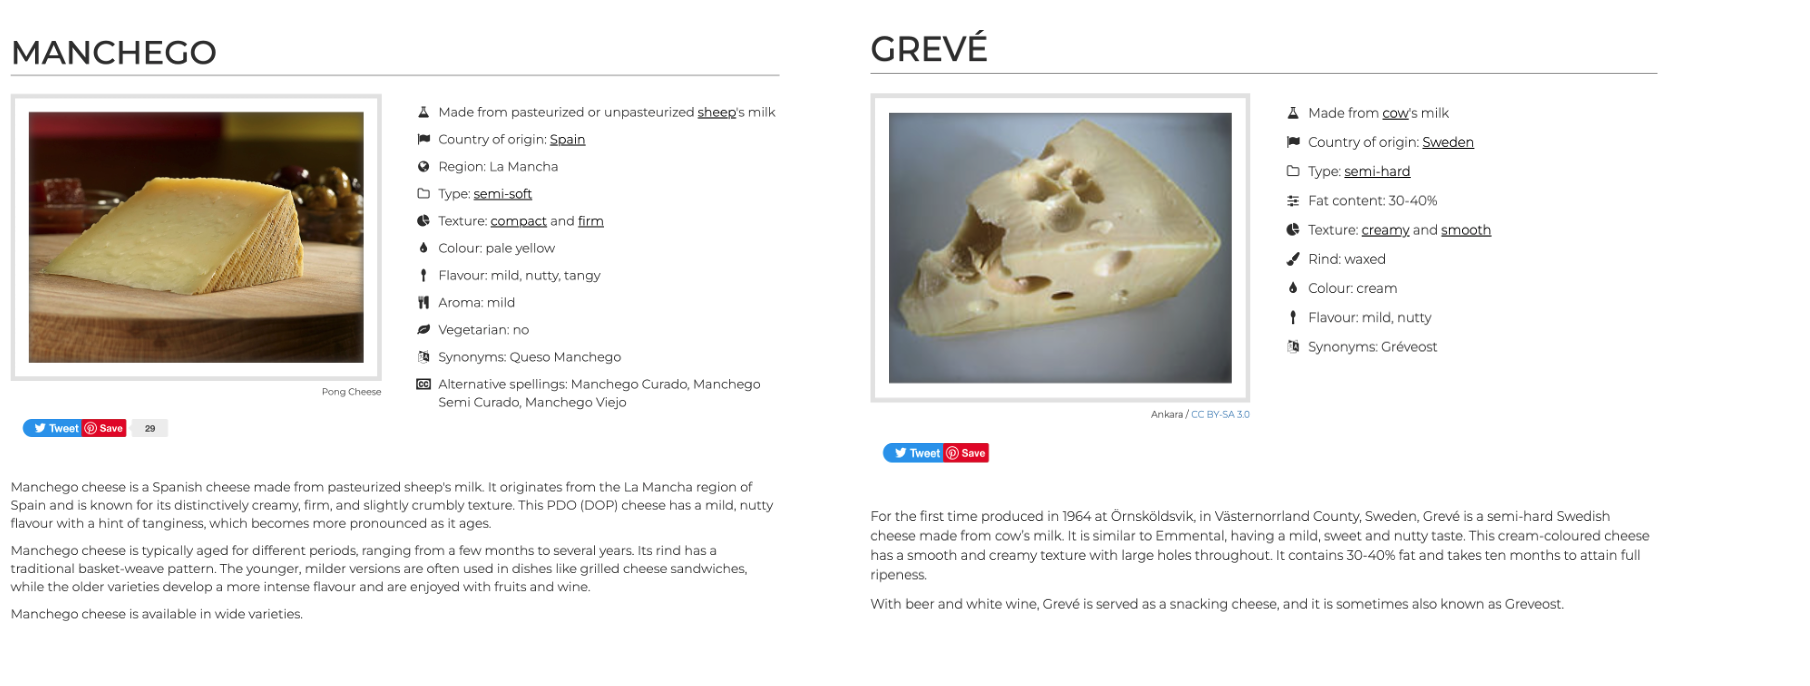


In [ ]:
import pandas as pd

word_search = "United States"
vector_string = "mild"

text_emb = model.encode(vector_string)
print(f"model provided embeddings for the string: '. {text_emb.tolist()}")
embeddings_str = ", ".join(map(str, text_emb.tolist()))
query = f"SELECT id, name, aroma, country_origin FROM {KEYSPACE_NAME}.{TABLE_NAME} WHERE description : '{word_search}' ORDER BY item_vector ANN OF [{embeddings_str}] LIMIT 7"
results = session.execute(query)
top_results = results._current_rows

with pd.option_context('display.max_rows', 7,
                       'display.max_columns', None,
                       'display.width', 2000,
                       'display.colheader_justify', 'center'):

    df = pd.DataFrame(top_results, columns = [ 'ID', 'Name', 'Aroma', 'Country' ])
    print(df)

model provided embeddings for the string: '. [0.03243834897875786, 0.0066909873858094215, 0.06076224148273468, 0.06481488049030304, 0.03716734051704407, -0.07059403508901596, 0.033396732062101364, 0.04919395595788956, -0.0742311030626297, 0.029607132077217102, 0.06896451115608215, 0.02429959923028946, 0.04189968854188919, 0.10207109898328781, 0.02089690789580345, 0.045414891093969345, 0.073174849152565, -0.05797392502427101, -0.0934007465839386, 0.10894758999347687, -0.04960474371910095, 0.06574828177690506, -0.016597796231508255, 0.0054901400581002235, 0.015942279249429703, -0.008750399574637413, 0.01981739141047001, 0.08379903435707092, 0.02894436940550804, -0.014958054758608341, -0.05095924437046051, 0.07395981252193451, 0.028841761872172356, -0.024615073576569557, -0.059501130133867264, 0.020662810653448105, -0.02799028716981411, -0.0016368086216971278, 0.038042694330215454, 0.0240256916731596, -0.03619447723031044, -0.0539785660803318, 0.010742796584963799, -0.01721983030438423, 0